In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
from PIL import Image
from torchvision.models import vgg19

# controllare

# Load image 

In [2]:
def load_image(image_path, device, output_size=None):
    """Loads an image by transforming it into a tensor."""
    img = Image.open(image_path)

    output_dim = None
    if output_size is None:
        output_dim = (img.size[1], img.size[0])
    elif isinstance(output_size, int):
        output_dim = (output_size, output_size)
    elif isinstance(output_size, tuple):
        if (len(output_size) == 2) and isinstance(output_size[0], int) and isinstance(output_size[1], int):
            output_dim = output_size
    else:
        raise ValueError("ERROR: output_size must be an integer or a 2-tuple of (height, width) if provided.")

    torch_loader = transforms.Compose(
        [
            transforms.Resize(output_dim),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #this line is to renormalize
        ]
    )
    
    img_tensor = torch_loader(img).unsqueeze(0)
    return img_tensor.to(device)

In [3]:
def image_style_transfer(content_path, style_path, output_size=300):
    """Implements neural style transfer on a content image using a style image, applying provided configuration."""
    ...
    
    # load content and style images
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_tensor = load_image(content_path, device, output_size=output_size)
    output_size = (content_tensor.shape[2], content_tensor.shape[3])
    style_tensor = load_image(style_path, device, output_size=output_size)
    
    return content_tensor, style_tensor

In [4]:
"""Gloria´s paths"""
content_path = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/content1.jpg"
style_path = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/style3.jpg"
content_path = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/content images/san-francisco-usa.jpg"
style_path = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/style images/mosaic.jpg"

content_tensor, style_tensor = image_style_transfer(content_path, style_path,output_size=int(300))

In [5]:
print(content_tensor.shape)
print(style_tensor.shape)

torch.Size([1, 3, 300, 300])
torch.Size([1, 3, 300, 300])


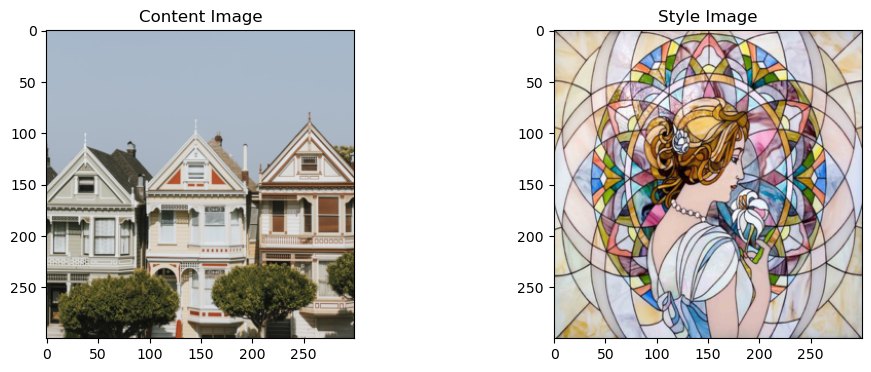

In [6]:
content_show = transforms.ToPILImage()(torchvision.utils.make_grid(content_tensor.cpu()))
style_show = transforms.ToPILImage()(torchvision.utils.make_grid(style_tensor.cpu()))

# Display the original content, style image, and random noise images
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(content_show)
axs[0].set_title("Content Image")

axs[1].imshow(style_show)
axs[1].set_title("Style Image")

plt.show()

# Utils 

In [7]:
class ImageStyleTransfer_VGG19(nn.Module):
    def __init__(self):
        super(ImageStyleTransfer_VGG19, self).__init__()

        self.chosen_features = {0: 'conv11', 5: 'conv21', 10: 'conv31', 19: 'conv41', 28: 'conv51'}
        self.model = vgg19(weights='DEFAULT').features[:29]

    def forward(self, x):
        feature_maps = dict()
        for idx, layer in enumerate(self.model):
            x = layer(x)
            if idx in self.chosen_features.keys():
                feature_maps[self.chosen_features[idx]] = x
        
        return feature_maps


def _get_content_loss(content_feature, generated_feature):
    """Compute MSE between content feature map and generated feature map as content loss."""
    return torch.mean((generated_feature - content_feature) ** 2)


def _get_style_loss(style_feature, generated_feature):
    """Compute MSE between gram matrix of style feature map and of generated feature map as style loss."""
    _, channel, height, width = generated_feature.shape
    style_gram = style_feature.view(channel, height*width).mm(
        style_feature.view(channel, height*width).t()
    )
    generated_gram = generated_feature.view(channel, height*width).mm(
        generated_feature.view(channel, height*width).t()
    )

    return torch.mean((generated_gram - style_gram) ** 2)


def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [8]:
def train_image(content, style, generated, device, output_dir, output_img_fmt, content_img_name, style_img_name, verbose=False):
    """Update the output image using pre-trained VGG19 model."""
    model = ImageStyleTransfer_VGG19().to(device).eval()    # freeze parameters in the model

    # set default value for each configuration if not specified in train_config
    num_epochs = 1000
    lr = 1
    alpha = 1e5
    beta = 5e2
    capture_content_features_from = {'conv11', 'conv21', 'conv31', 'conv41', 'conv51'}
    capture_style_features_from = {'conv11', 'conv21', 'conv31', 'conv41', 'conv51'}
            
    # check if values passed to capture_content_features_from and capture_style_features_from are valid
    if not isinstance(capture_content_features_from, set):
        if isinstance(capture_content_features_from, dict):
            capture_content_features_from = set(capture_content_features_from.keys())
        elif isinstance(capture_content_features_from, str):
            capture_content_features_from = set([item.strip() for item in capture_content_features_from.split(',')])
        else:
            print(f"ERROR: invalid value for 'capture_content_features_from' in training configuration file: {capture_content_features_from}.")
            return 0
        
    if not capture_content_features_from.issubset({'conv11', 'conv21', 'conv31', 'conv41', 'conv51'}):
        print(f"ERROR: invalid value for 'capture_content_features_from' in training configuration file: {capture_content_features_from}.")
        return 0
    
    if not isinstance(capture_style_features_from, set):
        if isinstance(capture_style_features_from, dict):
            capture_style_features_from = set(capture_style_features_from.keys())
        elif isinstance(capture_style_features_from, str):
            capture_style_features_from = set([item.strip() for item in capture_style_features_from.split(',')])
        else:
            print(f"ERROR: invalid value for 'capture_style_features_from' in training configuration file: {capture_style_features_from}.")
            return 0
        
    if not capture_style_features_from.issubset({'conv11', 'conv21', 'conv31', 'conv41', 'conv51'}):
        print(f"ERROR: invalid value for 'capture_style_features_from' in training configuration file: {capture_style_features_from}.")
        return 0

    optimizer = torch.optim.Adam([generated], lr=lr)
    intermediate_dir = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/intermediate"
    #if verbose:
        # create a directory to save intermediate results
        #intermediate_dir = os.path.join(output_dir, f'nst-{content_img_name}-{style_img_name}-intermediate')
 
    for epoch in range(num_epochs):
        print(epoch)
        # get features maps of content, style and generated images from chosen layers
        content_features = model(content)
        style_features = model(style)
        generated_features = model(generated)

        content_loss = style_loss = 0

        for layer_name in generated_features.keys():
            content_feature = content_features[layer_name]
            style_feature = style_features[layer_name]
            generated_feature = generated_features[layer_name]

            if layer_name in capture_content_features_from:
                content_loss_per_feature = _get_content_loss(content_feature, generated_feature)
                content_loss += content_loss_per_feature
            
            if layer_name in capture_style_features_from:
                style_loss_per_feature = _get_style_loss(style_feature, generated_feature)
                style_loss += style_loss_per_feature

        # compute loss 
        total_loss = alpha * content_loss + beta * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # print loss value and save progress every 200 epochs
        if verbose:
            if (epoch + 1) % 5 == 0:
                save_image(generated, os.path.join(intermediate_dir, f'nst-{content_img_name}-{style_img_name}-{epoch + 1}.{output_img_fmt}'))

                print(f"\tEpoch {epoch + 1}/{num_epochs}, loss = {total_loss.item()}")
    
    if verbose:
        print("\t================================")
        print(f"\tIntermediate images are saved in directory: '{intermediate_dir}'")
        print("\t================================")

    return 1


In [9]:
# train model
from torchvision.utils import save_image

output_dir = "/home/gloria/Scrivania/Vision_and_cognitive_system/content_style/intermediate"
output_img_fmt = "jpg"
content_img_name = 'house2' 
style_img_name = 'mosaic'
generated_tensor = content_tensor.clone().requires_grad_(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
success = train_image(content_tensor, style_tensor, generated_tensor, device, output_dir, output_img_fmt, content_img_name, style_img_name, verbose=True)

# save output image to specified directory
if success:
    save_image(generated_tensor, os.path.join(output_dir, f'nst-{content_img_name}-{style_img_name}-final.{output_img_fmt}'))


KeyboardInterrupt: 